# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this project, I built a deep neural net classifier for the German Traffic Sign Dataset. I conducted basic data exploration, performed data pre-processing, augmented with jittered data, developed and trained a neural network, and then evaluated the model.

---
## Step 0: Load The Data

In [1]:
# Import modules
import pickle
import math
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import numpy as np
import skimage
from skimage import transform
from skimage import filters
from skimage import color
import sklearn
import tensorflow as tf
import scipy
from scipy import misc

In [2]:
# Load pickled data
training_file = '../Documents/Udacity/SDCND/traffic-signs-data/train.p'
testing_file = '../Documents/Udacity/SDCND/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# These variables will store all the training and test data
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
# Number of training & testing examples
n_train = len(X_train)
n_test = len(X_test)

# Shape of traffic sign image
image_shape = str(len(X_train[0])) + "x" + str(len(X_train[0][0]))

# Number of unique classes/labels in the dataset
n_classes = max(train['labels']) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32x32
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

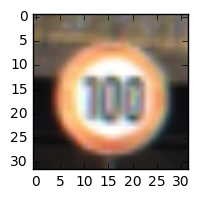

In [4]:
index = random.randint(0,len(X_train))
plt.figure(figsize=(2,2))
plt.imshow(X_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data.

# Normalize the data around 0.
X_train = (X_train + (-128)) / 128
X_test = (X_test + (-128)) / 128

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I normalized the data around 0 in order to promote faster/more robust convergence with the gradient descent algorithm. I considered converting the image into another color mode (a move employed, for example, by Sermanet and LeCun (http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) in using YUV images), but decided against it since I didn't see that approach used by other researchers.

In [6]:
### Generate data additional data

# Augment the training set with jittered data.

# Create 2 numpy arrays to hold the new jittered images.
# These are necessary since numpy will create a new array when appending to an array.
new_images = np.zeros((len(X_train)*2, 32, 32, 3), np.float32)
new_labels = np.zeros((len(X_train)*2), np.float32)

In [7]:
# Loop through each image in the training set.
# Store two jittered images in the new_images array and two of the correct labels in new_labels
for i in range(n_train):
    # Append 1 random section & 1 random rotation to new_images array
    image = X_train[i]
    label = y_train[i]
    
    # Make a random selection of the image by resizing it randomly,
    # and then cropping it randomly back to 32x32
    new_size = random.randrange(33,42)
    enlarged = transform.resize(image, [new_size, new_size, 3])
    crop_left = random.randrange(0,new_size-32)
    crop_right = new_size-32 - crop_left
    crop_top = random.randrange(0,new_size-32)
    crop_bottom = new_size-32 - crop_top
    random_selection = skimage.util.crop(enlarged, ((crop_top, crop_bottom),(crop_left, crop_right),(0,0)))
    index = 2*i
    new_images[index] = random_selection
    new_labels[index] = label

    # Make a random rotation of the image (between -10 and 10 degrees) 
    random_rotation = transform.rotate(image, (random.random()-0.5)*20)
    new_images[index+1, :] = random_rotation
    new_labels[index+1] = label

In [8]:
# Append the new images to the training data
X_train_all = np.concatenate((X_train, new_images))
y_train_all = np.concatenate((y_train, new_labels))

n_train = len(X_train_all)
print("The training data now contains " + str(len(X_train_all)) + " examples.")

The training data now contains 117627 examples.


In [9]:
### Split the data into training/validation sets here.
X_train = []
y_train = []
X_validation = []
y_validation = []

for i in range(n_train):
    if i%10 == 0:                         ## Every 10th data point should be appended to the validation set.
        X_validation.append(X_train_all[i])
        y_validation.append(y_train_all[i])
    else:
        X_train.append(X_train_all[i])
        y_train.append(y_train_all[i])

# Shuffle the training and validation sets
shuffle = sklearn.utils.shuffle

X_train, y_train = shuffle(X_train, y_train)
X_validation, y_validation = shuffle(X_validation, y_validation)

print("The training set has " + str(len(X_train)) + " data points.")
print("The validation set has " + str(len(X_validation)) + " data points.")

The training set has 105864 data points.
The validation set has 11763 data points.


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I generated additional jittered data, following the general approach recommended by Sermanet and LeCun. For each image in the training dataset, I created two additional images: one that is a random subset of the image and one that is randomly rotated by an angle between +/- 10 degrees. The subset image is useful because a traffic sign classifier needs to work on images taken at various distances from the sign, which might result in images of slightly different sizes. The rotated image also improves the robustness of the final model to small differences in the images.

To create a validation set, I separated about 10% of the data from the augmented training dataset, yielding 105,864 training data points and 11,763 validation images.

In [10]:
### Convolutional neural net architecture

def NeuralNet(x, keep_prob):
    
    depth = {
        'conv1': 16,
        'conv2': 32,
        'fullconn1': 1024,
        'fullconn2': 84,
        'fullconn3': 43
    }
   
    sigma = {
        'conv1': 0.1,
        'conv2': 0.1,
        'fullconn1': 0.1,
        'fullconn2': 0.1,
        'fullconn3': 0.1
    }

    weights = {
        'conv1': tf.Variable(tf.truncated_normal([5,5,3,depth['conv1']], stddev = sigma['conv1'])),
        'conv2': tf.Variable(tf.truncated_normal([5,5,depth['conv1'],depth['conv2']], stddev = sigma['conv2'])),
        'fullconn1': tf.Variable(tf.truncated_normal([8*8*depth['conv2'], depth['fullconn1']], stddev = sigma['fullconn1'])),
        'fullconn2': tf.Variable(tf.truncated_normal([depth['fullconn1'], depth['fullconn2']], stddev = sigma['fullconn2'])),
        'fullconn3': tf.Variable(tf.truncated_normal([depth['fullconn2'], depth['fullconn3']], stddev = sigma['fullconn3']))
    
    }
    
    bias = {
        'conv1': tf.Variable(tf.constant(0.1, shape=[depth['conv1']])),
        'conv2': tf.Variable(tf.constant(0.1, shape=[depth['conv2']])),
        'fullconn1': tf.Variable(tf.constant(0.1, shape=[depth['fullconn1']])),
        'fullconn2': tf.Variable(tf.constant(0.1, shape=[depth['fullconn2']])),
        'fullconn3': tf.Variable(tf.constant(0.1, shape=[depth['fullconn3']]))
    }
    
    ## Convolutional layer 1, with rectified linear activation, followed by max pooling
    ## 32x32x3 data becomes 16x16x16
    x = tf.nn.conv2d(x, weights['conv1'], [1,1,1,1], padding='SAME')
    x = tf.nn.bias_add(x, bias['conv1'])
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1,2,2,1], [1,2,2,1], padding='VALID')
    
    # Convolutional layer 2, with rectified linear activation, followed by max pooling
    ## 16x16x16 data becomes 8x8x32
    x = tf.nn.conv2d(x, weights['conv2'], [1,1,1,1], padding='SAME')
    x = tf.nn.bias_add(x, bias['conv2'])
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1,2,2,1], [1,2,2,1], padding='VALID')
    
    # Flatten the 8x8x32 data to 2048
    x = tf.contrib.layers.flatten(x)
                                                  
    # Fully connected layer with 1024 depth
    x = tf.add(tf.matmul(x, weights['fullconn1']), bias['fullconn1'])
    x = tf.nn.relu(x)
    
    # Fully connected layer with 84 depth
    x = tf.add(tf.matmul(x, weights['fullconn2']), bias['fullconn2'])
    x = tf.nn.relu(x)
    
    # Apply drop out to reduce overfitting
    x = tf.nn.dropout(x, keep_prob)
    
    # Fully connected layer with 43 depth (classes)
    logits = tf.add(tf.matmul(x, weights['fullconn3']), bias['fullconn3'])
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The first two layers of my model are 3x3 convolutions (with same size padding) followed by 2x2 max pooling. Each of these layers uses a Rectified Linear Unit as its non-linear activation function. Layer 1 takes the 32x32x3 images as input and returns a 16x16x16 weight matrix after the convolution and max pooling. Layer 2 changes this into a 8x8x32 weight matrix. Next, the model flattens the data to pass it through a fully connected layer with 1024 weights and then another fully connected layer with 84 weights. Each has a ReLU activation function. The model then employs dropout with 50% probability during training. Finally, there is a last fully connected layer that returns 43 outputs, a weight for each sign class.

In [11]:
### Train your model here.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None,32,32,3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

rate = 0.001
epochs = 10
batch_size = 128
len_data = len(X_train)
num_batches = math.ceil(len_data / batch_size)

logits = NeuralNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

def evaluate(x_data, y_data):
    sess = tf.get_default_session()
    accuracy = sess.run(accuracy_operation, feed_dict={x: x_data, y: y_data, keep_prob: 1.0})
    print("The accuracy is: " + str(accuracy))
    return accuracy

In [12]:
with tf.Session() as sess:
    
    sess.run(tf.initialize_all_variables())
    print('Training has begun...')
    
    # For each epoch, shuffle all the input/output data.
    # Then, update the model batch by batch.
    
    for i in range(epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for i in range(num_batches):
            start = batch_size*(i)
            end = batch_size*(i+1)
            if end >= len_data:
                end = len_data - 1
            batch_x = X_train[start:end]
            batch_y = y_train[start:end]
            sess.run(training_operation, feed_dict = {x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_acc = evaluate(X_validation, y_validation)
    tf.train.Saver().save(sess, 'convnet')

Training has begun...
The accuracy is: 0.902916
The accuracy is: 0.970841
The accuracy is: 0.982232
The accuracy is: 0.987333
The accuracy is: 0.988778
The accuracy is: 0.987928
The accuracy is: 0.991754
The accuracy is: 0.992349
The accuracy is: 0.993964
The accuracy is: 0.993454


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I employed the Adam Optimizer algorithm provided in TensorFlow, which provided much greater accuracy than using simple gradient descent. This algorithm is optimized for batch sizes of multiples of 128, so I used batch sizes of 128. Ten epochs were enough to get a sufficiently accurate model that was not overfit. I set the learning rate to 0.001. I initialized all weights within two standard deviations of a Gaussian distribution around 0 with SD = 0.1, and I initialized all biases to 0.


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I mainly used an empirical approach to tuning my model for better performance. I began with a model similar to the LeCun model proposed here (http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) by using 2 initial 5x5 convolutional layers. I used many fewer parameters (only having 6 and 16 layers of output rather than 108 as employed by Sermanet and LeCun) to make the model trainable on my computer. I used the same design for the fully connected layers as in the Udacity lab -- with ReLU activations and 400 followed by 84 outputs.

My first attempts at training did not lead to convergence -- the accuracy jumped up and down around 5%. I realized that I had not properly set the weight initialization, and so set the standard deviation of the weight initializations to 0.1. This led to a final accuracy around 80% after 10 epochs -- more reasonable.

I next decided to increase the number of output neurons in the first convolution layer from 6 to 50. This may allow the model to be more sensitive to information contained within patches of the original images, which may be necessary since signs generally look similar in many ways. This idea also makes sense since the models proposed by Sermanet and LeCun contain many more parameters in each layer. This change led to slightly better perfomance (83%), but it also slowed the training down significantly and may ultimately contribute to overfitting rather than generalized learning. I decided to return to using 6 output neurons on the first layer.

After this, I experimented with using a tanh activation instead of a rectified linear unit. These activation functions led to greater accuracy (87%), but they were slower to train; I decided to continue using the ReLU function as I continued tuning my model.

I next wanted to see how the batch size might affect performance. I decreased the batch size to 50, and then incremented by 50 to find the optimal size. The accuracy was highest at 150 per batch, which makes sense since the Adam Optimizer algorithm is optimized for batch sizes of size 128n. I opted to use a batch size of 128.

I also updated the weight initializing to reflect the best practice outlined by the Stanford CS231n team (http://cs231n.github.io/neural-networks-2/): the initial weights should be multiplied by sqrt(2/n), where n is the number of inbound neurons. This change significantly decreased the accuracy of my model, and so I reverted back to using a SD of 0.1 in the Gaussian that set my initial weights.

I also added batch normalization to each layer in my model (as outlined here: http://r2rt.com/implementing-batch-normalization-in-tensorflow.html), a change that increased the accuracy slightly as well. This became more complicated in practice, however, when testing on the validation data and especially so on single images or small sets of images -- so I abandoned this.

I then decided that increasing the weights in the initial convolutional layers would be necessary, though I opted for fewer than in some of the recommendations in the TensorFlow tutorial and significantly fewer than in Sermanet and LeCun's model. These changes were the breakthrough I needed to ensure accuracy close to 100% on the training set. I added a dropout layer to my architecture to prevent overfitting, and I felt confident in this model. When I tested on the testing data, the model was 95% accurate -- lower than I expected and had hoped for, but passable for a model trained on my MacBook.

My engagement with the TensorFlow documentation, with research literature, with practitioners' blogs, and with the dataset itself all made my work to create and improve this architecture a very productive learning opportunity.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [67]:
print("Testing has begun...")
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    new_saver = tf.train.import_meta_graph('convnet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    evaluate(X_test, y_test)

Testing has begun...
The accuracy is: 0.950911


In [22]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# Helper function that crops an image to 32x32.
# Requires "crop" tuple of left/right/top/bottom to cut off.
def prepare_img(file, crop):
    left, right, top, bottom = crop
    image = misc.imread(file)
    image = skimage.util.crop(image, ((top, bottom), (left, right), (0,0)))
    return transform.resize(image, [32,32,3])

stop = prepare_img('../Documents/Udacity/SDCND/stopsign.jpg', (100,50,0,37))
stop_label = 14

rightofway = prepare_img('../Documents/Udacity/SDCND/rightofwaysign.jpg', (190,60,0,0))
rightofway_label = 11

slash = prepare_img('../Documents/Udacity/SDCND/slashsign.jpeg', (73,90,40,60))
slash_label = 32

thirty = prepare_img('../Documents/Udacity/SDCND/30sign.jpeg', (95,35,50,181))
thirty_label = 1

slowright = prepare_img('../Documents/Udacity/SDCND/rightsign.jpg', (60,80,10,84))
slowright_label = 20

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [42]:
new_signs = [stop, rightofway, slash, thirty, slowright]
new_labels = [stop_label, rightofway_label, slash_label, thirty_label, slowright_label]

prediction = tf.nn.softmax(logits)
top = tf.nn.top_k(prediction, k=3)
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    new_saver = tf.train.import_meta_graph('convnet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    top = sess.run(top, feed_dict={x: new_signs, keep_prob: 1.0})

In [43]:
print(top)

TopKV2(values=array([[  1.00000000e+00,   7.94156474e-09,   2.25724869e-10],
       [  9.99937057e-01,   6.26911133e-05,   2.32625467e-07],
       [  3.60708475e-01,   3.20857167e-01,   1.26523882e-01],
       [  1.00000000e+00,   1.03891746e-19,   2.53394276e-20],
       [  1.00000000e+00,   1.29287148e-09,   2.21352520e-11]], dtype=float32), indices=array([[14, 17,  5],
       [11, 30, 28],
       [12, 32, 42],
       [ 1,  0,  2],
       [20, 28,  3]], dtype=int32))


These four images were classified correctly:


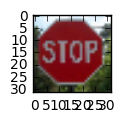

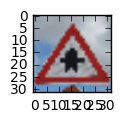

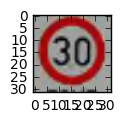

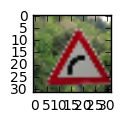

In [41]:
print("These four images were classified correctly:")
plt.figure(figsize=(1,1))
plt.imshow(stop)
plt.figure(figsize=(1,1))
plt.imshow(rightofway)
plt.figure(figsize=(1,1))
plt.imshow(thirty)
plt.figure(figsize=(1,1))
plt.imshow(slowright)
print("This image was classified incorrectly:")
plt.figure(figsize=(1,1))
plt.imshow(slash)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

My model was able to identify 4 out of 5 images correctly. This 80% accuracy is less than the model's performance on the validation data set (99%) and the test set (95%). The model was unable to classify one image likely because it was degraded from being resized to 32x32

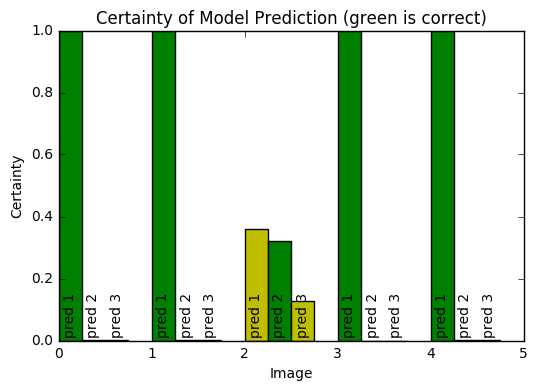

In [65]:
### Visualize the softmax probabilities here.

chart = plt.subplot()
width = 0.25
probs = top[0]
labels = top[1]

for i in range(5):
    probArray = probs[i]
    labelArray = labels[i]
    correctLabel = new_labels[i]
    
    for j in range(len(probArray)):
        if (labelArray[j] == correctLabel):
            c = 'g'
        else:
            c = 'y'
        chart.bar(i+j*width, probArray[j], width, color=c)
        chart.text(i+j*width+0.5*width, 0.01, 'pred %d' %(j+1), rotation='vertical', ha = 'center', va='bottom')

chart.set_ylabel('Certainty')
chart.set_xlabel('Image')
chart.set_title('Certainty of Model Prediction (green is correct)')

plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

Generally the model is very confident in its predictions, with certainties close to 1. In the case of the misclassified image, the model was not confident (36%) and the correct label was the second prediction (at 32%).